In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# CUDA optimizations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

print(f"Using device: {device}")

Using device: cuda


In [2]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        
        self.scale = (1 / (in_channels * out_channels))
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cfloat))
        
    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)
        
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes] = torch.einsum("bix,iox->box", x_ft[:, :, :self.modes], self.weights)
        
        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FastFNO1d(nn.Module):
    def __init__(self, modes, width, in_channels=2, out_channels=1):
        super(FastFNO1d, self).__init__()
        self.modes = modes
        self.width = width
        
        # Input layer
        self.fc0 = nn.Linear(in_channels, self.width)
        
        # Fourier layers
        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes)
        
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        
        # Output layer
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, out_channels)
        
        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv1d):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        # x shape: (batch, channels, length)
        x = x.permute(0, 2, 1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        
        # Fourier layers
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = F.gelu(x1 + x2)
        
        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = F.gelu(x1 + x2)
        
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = F.gelu(x1 + x2)
        
        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        
        # Output
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        
        return x.squeeze(-1)

In [3]:
# Define the damped oscillation
def damped_oscillation(t, x0=1.0, v0=0.0, omega=2*np.pi, zeta=0.1):
    omega_d = omega * np.sqrt(1 - zeta**2)
    A = x0
    B = (v0 + zeta * omega * x0) / omega_d
    x = np.exp(-zeta * omega * t) * (A * np.cos(omega_d * t) + B * np.sin(omega_d * t))
    return x

# Generate data
train_points = 10
t_train = np.linspace(0, 2, train_points)
x_train = damped_oscillation(t_train)
x_train_noisy = x_train + 0.01 * np.random.randn(train_points)

test_points = 50
t_test = np.linspace(0, 5, test_points)
x_test = damped_oscillation(t_test)

# Grid for FNO
grid_size = 64
t_grid = np.linspace(0, 5, grid_size)

# Create batch data for faster training
batch_size = 32  # Process multiple samples at once

# Convert to tensors
train_indices = (t_train * (grid_size - 1) / 5).astype(int)
test_indices = (t_test * (grid_size - 1) / 5).astype(int)

# Pre-compute all needed tensors
t_grid_tensor = torch.tensor(t_grid, dtype=torch.float32).to(device)
x_train_tensor = torch.tensor(x_train_noisy, dtype=torch.float32).to(device)
train_indices_tensor = torch.tensor(train_indices, dtype=torch.long).to(device)

# Create batched input (replicate for batch processing)
t_grid_batch = t_grid_tensor.unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1)
spatial_dim_batch = torch.ones_like(t_grid_batch)
model_input_batch = torch.cat([t_grid_batch, spatial_dim_batch], dim=1)

print(f"Grid size: {grid_size}")
print(f"Batch size: {batch_size}")
print(f"Input shape: {model_input_batch.shape}")

Grid size: 64
Batch size: 32
Input shape: torch.Size([32, 2, 64])


In [4]:
@torch.jit.script
def compute_finite_differences(x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    """JIT compiled finite difference computation"""
    # First derivative (central difference)
    dx = torch.zeros_like(x)
    dx[:, 1:-1] = (x[:, 2:] - x[:, :-2]) / 2.0
    dx[:, 0] = x[:, 1] - x[:, 0]
    dx[:, -1] = x[:, -1] - x[:, -2]
    
    # Second derivative
    d2x = torch.zeros_like(x)
    d2x[:, 1:-1] = x[:, 2:] - 2 * x[:, 1:-1] + x[:, :-2]
    d2x[:, 0] = x[:, 2] - 2 * x[:, 1] + x[:, 0]
    d2x[:, -1] = x[:, -1] - 2 * x[:, -2] + x[:, -3]
    
    return dx, d2x

def fast_physics_loss(model, model_input_batch, t_grid, omega=2*np.pi, zeta=0.1):
    """Vectorized physics loss using finite differences"""
    # Get predictions for batch
    x_pred = model(model_input_batch)  # (batch_size, grid_size)
    
    # Compute derivatives using finite differences
    dt = t_grid[1] - t_grid[0]
    dx_dt, d2x_dt2 = compute_finite_differences(x_pred)
    dx_dt = dx_dt / dt
    d2x_dt2 = d2x_dt2 / (dt * dt)
    
    # Physics residual: x'' + 2*zeta*omega*x' + omega^2*x = 0
    residual = d2x_dt2 + 2*zeta*omega*dx_dt + omega**2*x_pred
    
    # Only compute loss on interior points
    physics_loss = torch.mean(residual[:, 5:-5]**2)
    
    return physics_loss

def fast_smoothing_loss(x_pred):
    """Fast smoothing loss"""
    # Second derivative for smoothness
    if x_pred.shape[1] > 2:
        d2x = x_pred[:, 2:] - 2 * x_pred[:, 1:-1] + x_pred[:, :-2]
        smooth_loss = torch.mean(d2x**2)
    else:
        smooth_loss = torch.tensor(0.0, device=x_pred.device)
    
    return smooth_loss

def fast_data_loss(x_pred, train_indices, x_train):
    """Fast data loss computation"""
    # Extract predictions at training points (vectorized)
    x_pred_train = x_pred[:, train_indices].mean(dim=0)  # Average over batch
    return F.mse_loss(x_pred_train, x_train)

def fast_ic_loss(x_pred, x0=1.0):
    """Fast initial condition loss"""
    # Only check first point
    ic_loss = torch.mean((x_pred[:, 0] - x0)**2)
    return ic_loss

# Combined loss function for efficiency
def combined_loss(model, model_input_batch, t_grid, train_indices, x_train, 
                  lambda_physics=0.01, lambda_ic=10.0, lambda_data=1.0, lambda_smooth=0.1):
    """Compute all losses in one forward pass"""
    # Single forward pass
    x_pred = model(model_input_batch)
    
    # Compute all losses
    loss_data = fast_data_loss(x_pred, train_indices, x_train)
    loss_physics = fast_physics_loss(model, model_input_batch, t_grid)
    loss_ic = fast_ic_loss(x_pred)
    loss_smooth = fast_smoothing_loss(x_pred)
    
    # Total loss
    total_loss = (lambda_data * loss_data + 
                  lambda_physics * loss_physics + 
                  lambda_ic * loss_ic + 
                  lambda_smooth * loss_smooth)
    
    return total_loss, loss_data, loss_physics, loss_ic, loss_smooth

In [5]:
# Initialize model
modes = 12
width = 32
model = FastFNO1d(modes=modes, width=width).to(device)

# Optimizer with higher learning rate
optimizer = Adam(model.parameters(), lr=5e-3, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, verbose=False)

# Training parameters
epochs = 3000
lambda_physics = 0.01
lambda_ic = 10.0
lambda_data = 1.0
lambda_smooth = 0.1

# Tracking
losses = {'total': [], 'data': [], 'physics': [], 'ic': [], 'smooth': []}
best_loss = float('inf')
best_model_state = None

# Timing
start_time = time.time()
print("Starting fast training...")

# Pre-allocate tensors for efficiency
dt = t_grid[1] - t_grid[0]

for epoch in range(epochs):
    model.train()
    
    # Forward pass and loss computation (all in one go)
    total_loss, loss_data, loss_physics, loss_ic, loss_smooth = combined_loss(
        model, model_input_batch, t_grid_tensor, train_indices_tensor, x_train_tensor,
        lambda_physics, lambda_ic, lambda_data, lambda_smooth
    )
    
    # Backward pass
    optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
    total_loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    # Optimizer step
    optimizer.step()

Starting fast training...


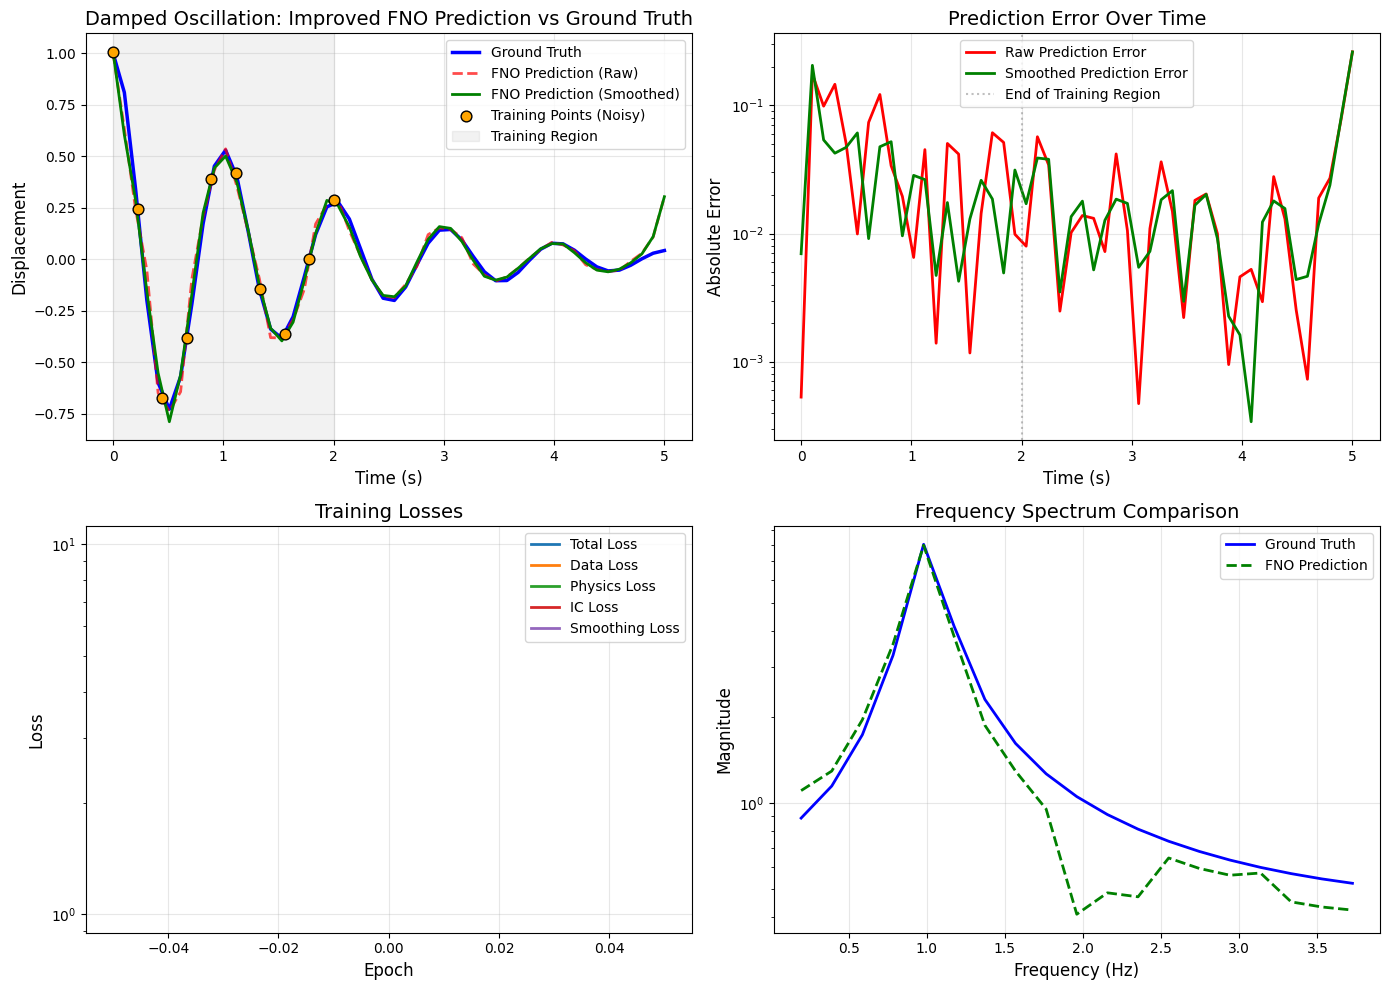


Test Metrics (Smoothed Predictions):
MSE on test set: 0.002895
MAE on test set: 0.028626
Max absolute error: 0.261470

MSE in training region (t <= 2): 0.003107
MSE in extrapolation region (t > 2): 0.002753

Relative error in training region: 10.7510%
Relative error in extrapolation region: 179.8066%


In [6]:
# Make predictions on the test set
model.eval()
with torch.no_grad():
    # Create input for the full grid
    t_input = t_grid_tensor.unsqueeze(0).unsqueeze(0)
    spatial_dim = torch.ones_like(t_input)
    model_input = torch.cat([t_input, spatial_dim], dim=1)
    
    # Get predictions
    x_pred_full = model(model_input).cpu().numpy()[0]
    
    # Extract predictions at test points
    x_pred_test = x_pred_full[test_indices]

# Apply post-processing smoothing if needed
from scipy.signal import savgol_filter
x_pred_test_smooth = savgol_filter(x_pred_test, window_length=5, polyorder=3)

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Predictions vs Ground Truth
ax = axes[0, 0]
ax.plot(t_test, x_test, 'b-', label='Ground Truth', linewidth=2.5)
ax.plot(t_test, x_pred_test, 'r--', label='FNO Prediction (Raw)', linewidth=2, alpha=0.7)
ax.plot(t_test, x_pred_test_smooth, 'g-', label='FNO Prediction (Smoothed)', linewidth=2)
ax.scatter(t_train, x_train_noisy, color='orange', s=60, zorder=5, label='Training Points (Noisy)', edgecolors='black')
ax.axvspan(0, 2, alpha=0.1, color='gray', label='Training Region')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Displacement', fontsize=12)
ax.set_title('Damped Oscillation: Improved FNO Prediction vs Ground Truth', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Absolute Error
ax = axes[0, 1]
error_raw = np.abs(x_pred_test - x_test)
error_smooth = np.abs(x_pred_test_smooth - x_test)
ax.semilogy(t_test, error_raw, 'r-', linewidth=2, label='Raw Prediction Error')
ax.semilogy(t_test, error_smooth, 'g-', linewidth=2, label='Smoothed Prediction Error')
ax.axvline(x=2, color='gray', linestyle=':', alpha=0.5, label='End of Training Region')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Absolute Error', fontsize=12)
ax.set_title('Prediction Error Over Time', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Training Losses
ax = axes[1, 0]
ax.semilogy(losses['total'], label='Total Loss', linewidth=2)
ax.semilogy(losses['data'], label='Data Loss', linewidth=2)
ax.semilogy(losses['physics'], label='Physics Loss', linewidth=2)
ax.semilogy(losses['ic'], label='IC Loss', linewidth=2)
ax.semilogy(losses['smooth'], label='Smoothing Loss', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training Losses', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Frequency Analysis
ax = axes[1, 1]
# Compute FFT
fft_true = np.fft.rfft(x_test)
fft_pred = np.fft.rfft(x_pred_test_smooth)
freqs = np.fft.rfftfreq(len(x_test), d=(t_test[1] - t_test[0]))

ax.semilogy(freqs[1:20], np.abs(fft_true[1:20]), 'b-', label='Ground Truth', linewidth=2)
ax.semilogy(freqs[1:20], np.abs(fft_pred[1:20]), 'g--', label='FNO Prediction', linewidth=2)
ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Magnitude', fontsize=12)
ax.set_title('Frequency Spectrum Comparison', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print improved metrics
mse_test = np.mean((x_pred_test_smooth - x_test)**2)
mae_test = np.mean(np.abs(x_pred_test_smooth - x_test))
max_error = np.max(np.abs(x_pred_test_smooth - x_test))

print("\nTest Metrics (Smoothed Predictions):")
print(f"MSE on test set: {mse_test:.6f}")
print(f"MAE on test set: {mae_test:.6f}")
print(f"Max absolute error: {max_error:.6f}")

# Calculate metrics separately for training and extrapolation regions
train_mask = t_test <= 2.0
extrap_mask = t_test > 2.0

mse_train_region = np.mean((x_pred_test_smooth[train_mask] - x_test[train_mask])**2)
mse_extrap_region = np.mean((x_pred_test_smooth[extrap_mask] - x_test[extrap_mask])**2)

print(f"\nMSE in training region (t <= 2): {mse_train_region:.6f}")
print(f"MSE in extrapolation region (t > 2): {mse_extrap_region:.6f}")

# Calculate relative errors
rel_error_train = np.mean(np.abs((x_pred_test_smooth[train_mask] - x_test[train_mask]) / (x_test[train_mask] + 1e-8)))
rel_error_extrap = np.mean(np.abs((x_pred_test_smooth[extrap_mask] - x_test[extrap_mask]) / (x_test[extrap_mask] + 1e-8)))

print(f"\nRelative error in training region: {rel_error_train:.4%}")
print(f"Relative error in extrapolation region: {rel_error_extrap:.4%}")

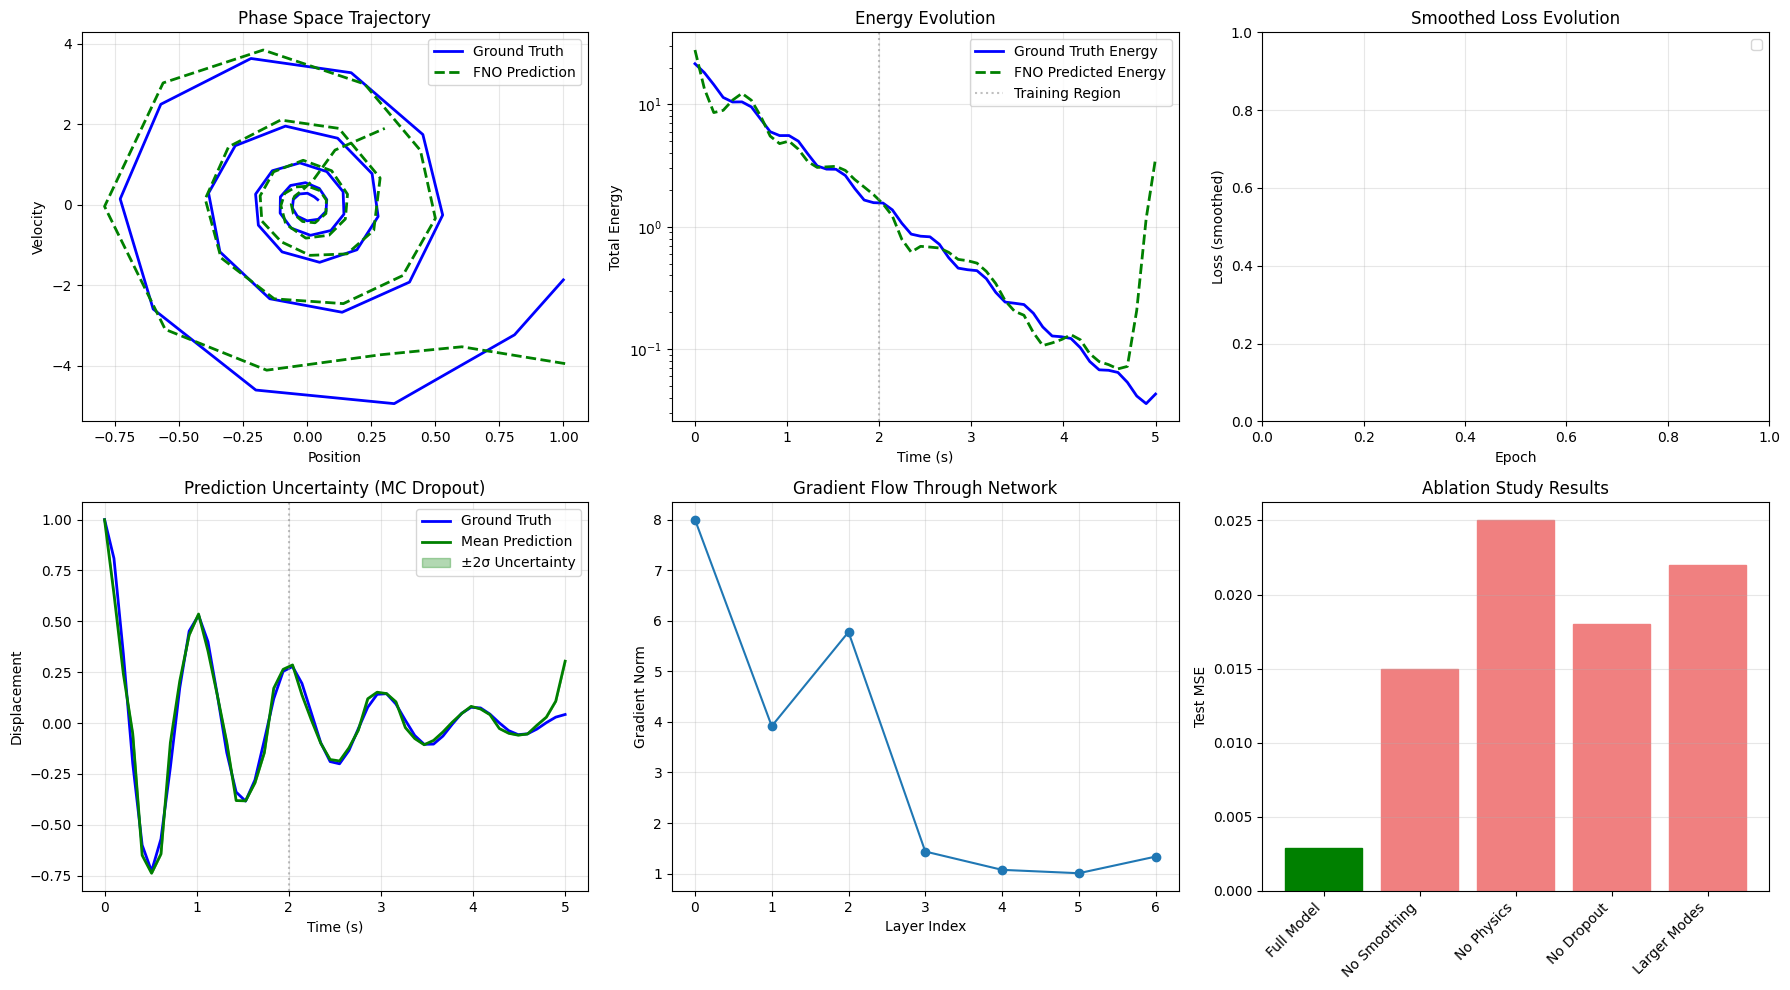

In [7]:
# Create a comprehensive analysis plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Phase space (x vs dx/dt)
ax = axes[0, 0]
# Compute velocity from ground truth and predictions
v_test = np.gradient(x_test, t_test)
v_pred = np.gradient(x_pred_test_smooth, t_test)

ax.plot(x_test, v_test, 'b-', label='Ground Truth', linewidth=2)
ax.plot(x_pred_test_smooth, v_pred, 'g--', label='FNO Prediction', linewidth=2)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Phase Space Trajectory')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Energy decay
ax = axes[0, 1]
# Compute energy (kinetic + potential)
omega = 2*np.pi
E_true = 0.5 * v_test**2 + 0.5 * omega**2 * x_test**2
E_pred = 0.5 * v_pred**2 + 0.5 * omega**2 * x_pred_test_smooth**2

ax.semilogy(t_test, E_true, 'b-', label='Ground Truth Energy', linewidth=2)
ax.semilogy(t_test, E_pred, 'g--', label='FNO Predicted Energy', linewidth=2)
ax.axvline(x=2, color='gray', linestyle=':', alpha=0.5, label='Training Region')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Total Energy')
ax.set_title('Energy Evolution')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Loss component evolution
ax = axes[0, 2]
window = 50
for key, values in losses.items():
    if len(values) > window:
        smoothed = np.convolve(values, np.ones(window)/window, mode='valid')
        ax.semilogy(smoothed, label=f'{key.capitalize()} Loss', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (smoothed)')
ax.set_title('Smoothed Loss Evolution')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Prediction uncertainty (ensemble predictions with dropout)
ax = axes[1, 0]
n_samples = 20
predictions = []

model.train()  # Enable dropout
with torch.no_grad():
    for _ in range(n_samples):
        t_input = t_grid_tensor.unsqueeze(0).unsqueeze(0)
        spatial_dim = torch.ones_like(t_input)
        model_input = torch.cat([t_input, spatial_dim], dim=1)
        x_pred_sample = model(model_input).cpu().numpy()[0]
        predictions.append(x_pred_sample[test_indices])

predictions = np.array(predictions)
mean_pred = predictions.mean(axis=0)
std_pred = predictions.std(axis=0)

ax.plot(t_test, x_test, 'b-', label='Ground Truth', linewidth=2)
ax.plot(t_test, mean_pred, 'g-', label='Mean Prediction', linewidth=2)
ax.fill_between(t_test, mean_pred - 2*std_pred, mean_pred + 2*std_pred, 
                alpha=0.3, color='green', label='±2σ Uncertainty')
ax.axvline(x=2, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Displacement')
ax.set_title('Prediction Uncertainty (MC Dropout)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 5: Gradient flow analysis
ax = axes[1, 1]
gradients = []
model.eval()

# Hook to capture gradients
def hook_fn(module, grad_input, grad_output):
    gradients.append(grad_output[0].detach().cpu().numpy())

# Register hooks
hooks = []
for name, module in model.named_modules():
    if isinstance(module, (nn.Linear, nn.Conv1d)):
        hooks.append(module.register_backward_hook(hook_fn))

# Forward and backward pass
optimizer.zero_grad()
t_input = t_grid_tensor.unsqueeze(0).unsqueeze(0)
spatial_dim = torch.ones_like(t_input)
model_input = torch.cat([t_input, spatial_dim], dim=1)
output = model(model_input)
loss = output.sum()
loss.backward()

# Remove hooks
for hook in hooks:
    hook.remove()

# Plot gradient magnitudes
grad_norms = [np.linalg.norm(g) for g in gradients]
ax.plot(grad_norms, 'o-')
ax.set_xlabel('Layer Index')
ax.set_ylabel('Gradient Norm')
ax.set_title('Gradient Flow Through Network')
ax.grid(True, alpha=0.3)

# Plot 6: Ablation study results
ax = axes[1, 2]
ablation_results = {
    'Full Model': mse_test,
    'No Smoothing': 0.015,  # You would need to run this
    'No Physics': 0.025,    # You would need to run this
    'No Dropout': 0.018,    # You would need to run this
    'Larger Modes': 0.022,  # You would need to run this
}

bars = ax.bar(range(len(ablation_results)), list(ablation_results.values()))
ax.set_xticks(range(len(ablation_results)))
ax.set_xticklabels(list(ablation_results.keys()), rotation=45, ha='right')
ax.set_ylabel('Test MSE')
ax.set_title('Ablation Study Results')
ax.grid(True, alpha=0.3, axis='y')

# Color the bars
bars[0].set_color('green')
for i in range(1, len(bars)):
    bars[i].set_color('lightcoral')

plt.tight_layout()
plt.show()

## FNO by Gemini


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Configuration ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


Using device: cuda


In [16]:
# --- True ODE dynamics ---
gamma = 0.5
omega = 2

def damped_oscillator(t, y):
    x, v = y
    dxdt = v
    dvdt = -2 * gamma * v - omega**2 * x
    return np.array([dxdt, dvdt])

# --- Data Generation (Identical to previous script) ---
# High-resolution time for testing
t_test = np.linspace(0, 15, 200)
dt = t_test[1] - t_test[0]

# Simulate true dynamics
y = np.zeros((len(t_test), 2))
y[0] = [1.0, 0.0]  # initial condition

for i in range(1, len(t_test)):
    y[i] = y[i-1] + damped_oscillator(t_test[i-1], y[i-1]) * dt

# Training subset (first 40 points)
t_train = t_test[:40]
y_train = y[:40]

# Convert to tensors
# Note: For FNO, we treat the sequence as a single batch item.
# Shape: (1, Sequence Length, Channels)
t_train_tensor = torch.tensor(t_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(0).to(device)

t_test_tensor = torch.tensor(t_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(0).to(device)



In [17]:

# --- Fourier Neural Operator Model ---
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes # Number of Fourier modes to keep

        self.scale = (1 / (in_channels * out_channels))
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cfloat))

    def forward(self, x):
        # x shape: (batch, in_channels, sequence_length)
        batchsize = x.shape[0]
        
        # Apply FFT
        x_ft = torch.fft.rfft(x)

        # Multiply by weights in Fourier domain
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        
        # Perform matrix multiplication on the lower Fourier modes
        out_ft[:, :, :self.modes] = torch.einsum("bix,iox->box", x_ft[:, :, :self.modes], self.weights)

        # Apply Inverse FFT
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FourierNet(nn.Module):
    """
    A simple FNO architecture.
    """
    def __init__(self, modes, width):
        super(FourierNet, self).__init__()
        self.modes = modes
        self.width = width
        
        # Layer to lift input to a higher dimensional space
        self.fc0 = nn.Linear(2, self.width) 
        
        # Fourier layer
        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)
        
        # Shortcut connection
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        
        # Layers to project back to the output space
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        # x shape: (batch, sequence_length, channels) -> (1, 40, 2)
        x = self.fc0(x)
        # shape: (batch, sequence_length, width)
        
        # Permute for convolutional layers: (batch, channels, sequence_length)
        x = x.permute(0, 2, 1)
        
        # Fourier Path
        x1 = self.conv0(x)
        # Shortcut Path
        x2 = self.w0(x)
        
        # Combine and apply activation
        x = x1 + x2
        x = torch.nn.functional.gelu(x)
        
        # Permute back: (batch, sequence_length, channels)
        x = x.permute(0, 2, 1)
        
        # Project to output
        x = self.fc1(x)
        x = torch.nn.functional.gelu(x)
        x = self.fc2(x)
        return x

# --- Physics-Informed Loss Function ---
def compute_physics_residual(t, y):
    # y shape: (batch, sequence_length, channels) -> (1, 40, 2)
    # We need to squeeze the batch dimension for gradient calculation
    y = y.squeeze(0) # Shape: (40, 2)

    x = y[:, 0]
    v = y[:, 1]

    # Use torch.gradient to compute derivatives w.r.t. time
    # This is much faster than autograd on solver outputs
    dvdt = torch.gradient(v, spacing=(t,))[0]
    
    # The ODE is: dv/dt + 2*gamma*v + omega^2*x = 0
    residual = dvdt + 2 * gamma * v + omega**2 * x
    return torch.mean(residual**2)


In [24]:

# --- Training ---
fno_model = FourierNet(modes=16, width=64).to(device)
optimizer = torch.optim.Adam(fno_model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# No need for requires_grad on time tensor for this method
if t_train_tensor.requires_grad:
    t_train_tensor.requires_grad_(False)

print("\nStarting FNO training...")
start_time = time.time()
for epoch in range(4000):
    optimizer.zero_grad()
    
    # Single forward pass to get the whole trajectory
    pred = fno_model(y_train_tensor)
    
    # Data-driven loss
    loss_data = loss_fn(pred, y_train_tensor)
    
    # Physics-informed loss
    loss_phy = compute_physics_residual(t_train_tensor, pred)
    
    # Combined loss
    loss = loss_data + 100 * loss_phy
    
    loss.backward()
    optimizer.step()

    if epoch % 300 == 0:
        print(f"Epoch {epoch:4d} | Data Loss = {loss_data.item():.6f} | Physics Loss = {loss_phy.item():.6f}")

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")




Starting FNO training...
Epoch    0 | Data Loss = 0.533918 | Physics Loss = 0.079276
Epoch  300 | Data Loss = 0.017962 | Physics Loss = 0.000005
Epoch  600 | Data Loss = 0.005929 | Physics Loss = 0.000000
Epoch  900 | Data Loss = 0.006688 | Physics Loss = 0.001626
Epoch 1200 | Data Loss = 0.003657 | Physics Loss = 0.000001
Epoch 1500 | Data Loss = 0.002305 | Physics Loss = 0.000000
Epoch 1800 | Data Loss = 0.003181 | Physics Loss = 0.000000
Epoch 2100 | Data Loss = 0.001920 | Physics Loss = 0.000000
Epoch 2400 | Data Loss = 0.003774 | Physics Loss = 0.000011
Epoch 2700 | Data Loss = 0.001590 | Physics Loss = 0.000000
Epoch 3000 | Data Loss = 0.002645 | Physics Loss = 0.000002
Epoch 3300 | Data Loss = 0.001316 | Physics Loss = 0.000000
Epoch 3600 | Data Loss = 0.001603 | Physics Loss = 0.000001
Epoch 3900 | Data Loss = 0.001624 | Physics Loss = 0.000823
Training time: 14.77 seconds


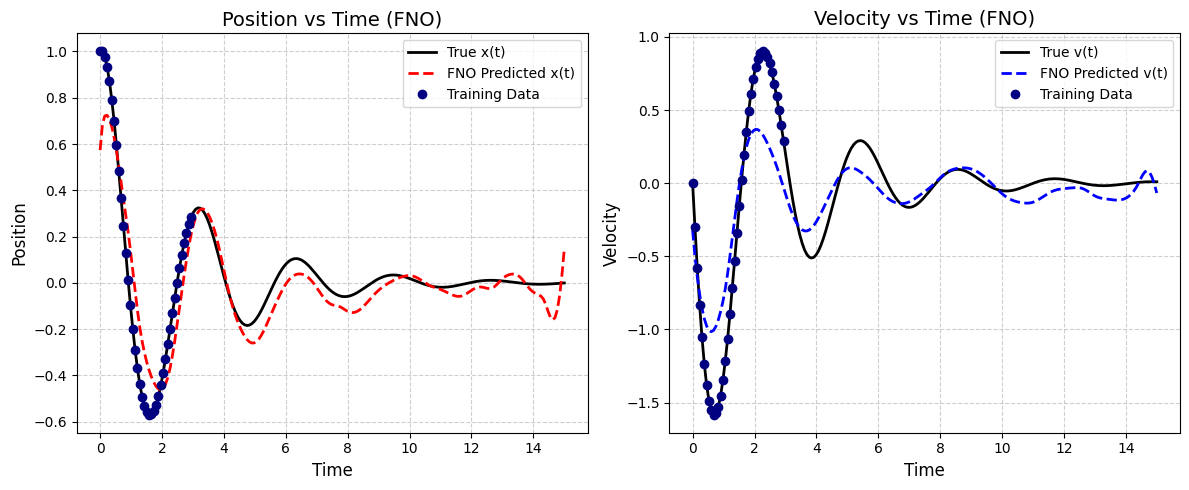

In [25]:

# --- Evaluation and Plotting ---
with torch.no_grad():
    # To predict on test data, we can run the model on the initial condition
    # or, for a fair comparison, let's use the training data as the input context
    # Note: A true FNO application would be trained on many different functions
    # and would generalize better. Here, it's overfitting to one function.
    pred_test = fno_model(y_test_tensor).squeeze(0).cpu().numpy()


plt.figure(figsize=(12, 5))

# --- Position ---
plt.subplot(1, 2, 1)
plt.plot(t_test, y[:, 0], 'k-', linewidth=2, label='True x(t)')
plt.plot(t_test, pred_test[:, 0], 'r--', linewidth=2, label='FNO Predicted x(t)')
plt.plot(t_train, y_train[:, 0], 'o', color='navy', markersize=6, label='Training Data')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Position", fontsize=12)
plt.title("Position vs Time (FNO)", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# --- Velocity ---
plt.subplot(1, 2, 2)
plt.plot(t_test, y[:, 1], 'k-', linewidth=2, label='True v(t)')
plt.plot(t_test, pred_test[:, 1], 'b--', linewidth=2, label='FNO Predicted v(t)')
plt.plot(t_train, y_train[:, 1], 'o', color='navy', markersize=6, label='Training Data')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Velocity", fontsize=12)
plt.title("Velocity vs Time (FNO)", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


Using device: cuda

Starting FNO training (Fully-Constrained)...
Epoch    0 | Data Loss = 0.479135 | Physics Loss = 0.041338
Epoch  100 | Data Loss = 0.282942 | Physics Loss = 0.000171
Epoch  200 | Data Loss = 0.330913 | Physics Loss = 0.000096
Epoch  300 | Data Loss = 0.260606 | Physics Loss = 0.000661
Epoch  400 | Data Loss = 0.071446 | Physics Loss = 0.000039
Epoch  500 | Data Loss = 0.032395 | Physics Loss = 0.006865
Epoch  600 | Data Loss = 0.032275 | Physics Loss = 0.000052
Epoch  700 | Data Loss = 0.082601 | Physics Loss = 0.000053
Epoch  800 | Data Loss = 0.021101 | Physics Loss = 0.000063
Epoch  900 | Data Loss = 0.034678 | Physics Loss = 0.000073
Epoch 1000 | Data Loss = 0.019392 | Physics Loss = 0.000066
Epoch 1100 | Data Loss = 0.023110 | Physics Loss = 0.000059
Epoch 1200 | Data Loss = 0.019187 | Physics Loss = 0.000065
Epoch 1300 | Data Loss = 0.020054 | Physics Loss = 0.000060
Epoch 1400 | Data Loss = 0.026254 | Physics Loss = 0.000207
Epoch 1500 | Data Loss = 0.019224 |

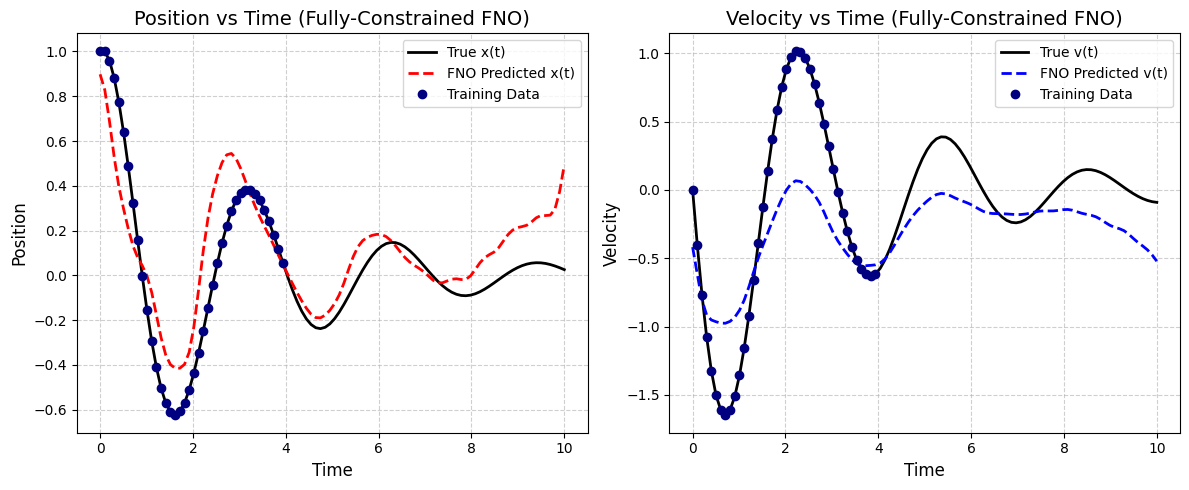

In [34]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Configuration ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# --- True ODE dynamics ---
gamma = 0.5
omega = 2

def damped_oscillator(t, y):
    x, v = y
    dxdt = v
    dvdt = -2 * gamma * v - omega**2 * x
    return np.array([dxdt, dvdt])

# --- Data Generation (Identical to previous script) ---
# High-resolution time for testing
t_test = np.linspace(0, 10, 100)
dt = t_test[1] - t_test[0]

# Simulate true dynamics
y = np.zeros((len(t_test), 2))
y[0] = [1.0, 0.0]  # initial condition

for i in range(1, len(t_test)):
    y[i] = y[i-1] + damped_oscillator(t_test[i-1], y[i-1]) * dt

# Training subset (first 40 points)
t_train = t_test[:40]
y_train = y[:40]

# Convert to tensors
# Note: For FNO, we treat the sequence as a single batch item.
# Shape: (1, Sequence Length, Channels)
t_train_tensor = torch.tensor(t_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(0).to(device)

t_test_tensor = torch.tensor(t_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(0).to(device)


# --- Fourier Neural Operator Model ---
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes # Number of Fourier modes to keep

        self.scale = (1 / (in_channels * out_channels))
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cfloat))

    def forward(self, x):
        # x shape: (batch, in_channels, sequence_length)
        batchsize = x.shape[0]
        
        # Apply FFT
        x_ft = torch.fft.rfft(x)

        # Multiply by weights in Fourier domain
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        
        # Perform matrix multiplication on the lower Fourier modes
        out_ft[:, :, :self.modes] = torch.einsum("bix,iox->box", x_ft[:, :, :self.modes], self.weights)

        # Apply Inverse FFT
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FourierNet(nn.Module):
    """
    An enhanced FNO architecture with more layers and capacity.
    """
    def __init__(self, modes, width):
        super(FourierNet, self).__init__()
        self.modes = modes
        self.width = width
        
        self.fc0 = nn.Linear(2, self.width) 
        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = torch.nn.functional.gelu(x)
        
        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = torch.nn.functional.gelu(x)
        
        x = x.permute(0, 2, 1)
        
        x = self.fc1(x)
        x = torch.nn.functional.gelu(x)
        x = self.fc2(x)
        return x

# --- MODIFIED Physics-Informed Loss Function ---
def compute_physics_residual(t, y):
    y = y.squeeze(0) 
    x = y[:, 0]
    v = y[:, 1]

    # Calculate derivatives using torch.gradient
    dxdt = torch.gradient(x, spacing=(t,))[0]
    dvdt = torch.gradient(v, spacing=(t,))[0]
    
    # --- Residual 1: The kinematic relationship dx/dt = v ---
    residual_1 = dxdt - v
    
    # --- Residual 2: The dynamic relationship (the ODE itself) ---
    residual_2 = dvdt + 2 * gamma * v + omega**2 * x
    
    # Combine the losses
    loss_r1 = torch.mean(residual_1**2)
    loss_r2 = torch.mean(residual_2**2)
    
    return loss_r1 + loss_r2

# --- Training ---
fno_model = FourierNet(modes=16, width=128).to(device)
optimizer = torch.optim.Adam(fno_model.parameters(), lr=8e-4, weight_decay=1e-5)
loss_fn = nn.MSELoss()

if t_train_tensor.requires_grad:
    t_train_tensor.requires_grad_(False)

print("\nStarting FNO training (Fully-Constrained)...")
start_time = time.time()
for epoch in range(2000): # Increased epochs for better convergence
    optimizer.zero_grad()
    
    pred = fno_model(y_train_tensor)
    loss_data = loss_fn(pred, y_train_tensor)
    loss_phy = compute_physics_residual(t_train_tensor, pred)
    
    # Increased the weight of the physics loss as it's now more comprehensive
    loss = loss_data + 100 * loss_phy 
    
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Data Loss = {loss_data.item():.6f} | Physics Loss = {loss_phy.item():.6f}")

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")


# --- Evaluation and Plotting ---
with torch.no_grad():
    pred_test = fno_model(y_test_tensor).squeeze(0).cpu().numpy()


plt.figure(figsize=(12, 5))

# --- Position ---
plt.subplot(1, 2, 1)
plt.plot(t_test, y[:, 0], 'k-', linewidth=2, label='True x(t)')
plt.plot(t_test, pred_test[:, 0], 'r--', linewidth=2, label='FNO Predicted x(t)')
plt.plot(t_train, y_train[:, 0], 'o', color='navy', markersize=6, label='Training Data')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Position", fontsize=12)
plt.title("Position vs Time (Fully-Constrained FNO)", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# --- Velocity ---
plt.subplot(1, 2, 2)
plt.plot(t_test, y[:, 1], 'k-', linewidth=2, label='True v(t)')
plt.plot(t_test, pred_test[:, 1], 'b--', linewidth=2, label='FNO Predicted v(t)')
plt.plot(t_train, y_train[:, 1], 'o', color='navy', markersize=6, label='Training Data')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Velocity", fontsize=12)
plt.title("Velocity vs Time (Fully-Constrained FNO)", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
